<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/RL_01_01_Gridworld(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install tensorflow

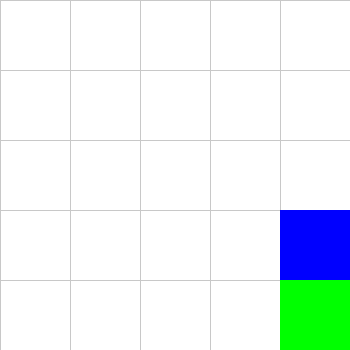

KeyboardInterrupt: 

In [2]:
import numpy as np
import tensorflow as tf
import random
import cv2
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# GridWorld 환경
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size - 1, self.size - 1]
        return self.get_state()

    def get_state(self):
        return self.agent_pos[0] * self.size + self.agent_pos[1]

    def step(self, action):
        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1   # 위로 이동 → 행(row) 감소
        elif action == 1 and self.agent_pos[0] < self.size - 1:
            self.agent_pos[0] += 1   # 아래로 이동 → 행(row) 증가
        elif action == 2 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1    # 왼쪽 이동 → 열(col) 감소
        elif action == 3 and self.agent_pos[1] < self.size - 1:
            self.agent_pos[1] += 1     # 오른쪽 이동 → 열(col) 증가

        done = self.agent_pos == self.goal_pos
        reward = 1.0 if done else -0.01
        return self.get_state(), reward, done

    def render(self, delay=200):
        clear_output(wait=True)  # 출력 누적 방지
        cell_size = 70
        img = np.ones((self.size * cell_size, self.size * cell_size, 3), dtype=np.uint8) * 255

        # 격자 그리기
        for i in range(self.size):
            for j in range(self.size):
                x, y = j * cell_size, i * cell_size
                cv2.rectangle(img, (x, y), (x + cell_size, y + cell_size), (200, 200, 200), 1)

        # 에이전트: 파랑
        ax, ay = self.agent_pos[1] * cell_size, self.agent_pos[0] * cell_size
        cv2.rectangle(img, (ax, ay), (ax + cell_size, ay + cell_size), (255, 0, 0), -1)

        # 목표: 초록
        gx, gy = self.goal_pos[1] * cell_size, self.goal_pos[0] * cell_size
        cv2.rectangle(img, (gx, gy), (gx + cell_size, gy + cell_size), (0, 255, 0), -1)

        cv2_imshow(img)
        time.sleep(delay / 1000.0)

# Q-network
class QNet(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(QNet, self).__init__()
        self.d1 = tf.keras.layers.Dense(32, activation='relu', input_shape=(state_size,))
        self.d2 = tf.keras.layers.Dense(32, activation='relu')
        self.out = tf.keras.layers.Dense(action_size, activation='linear')

    """
    TensorFlow의 서브클래싱 모델 (tf.keras.Model 상속) 방식에서는
    모델이 어떻게 forward pass를 처리할지를 직접 call()에서 정의해야 합니다.
    cf.)
    Sequential 또는 Functional API	❌ 필요 없음 (레이어 순서 자동 처리)
    Subclassing API (class QNet(tf.keras.Model))	✅ 꼭 필요
    """
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.out(x)

# 하이퍼파라미터
grid_size = 5
state_size = grid_size * grid_size
action_size = 4
episodes = 300

gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
learning_rate = 0.01

env = GridWorld(grid_size)
model = QNet(state_size, action_size)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# 학습 루프
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_input = tf.one_hot(state, state_size)
        state_input = tf.reshape(state_input, [1, state_size])

        if np.random.rand() < epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = model.predict(state_input, verbose=0)
            action = np.argmax(q_values[0])

        next_state, reward, done = env.step(action)
        next_state_input = tf.one_hot(next_state, state_size)
        next_state_input = tf.reshape(next_state_input, [1, state_size])

        target_q = model.predict(state_input, verbose=0)
        if done:
            target_q[0][action] = reward
        else:
            next_q = model.predict(next_state_input, verbose=0)
            target_q[0][action] = reward + gamma * np.max(next_q[0])

        model.fit(state_input, target_q, epochs=1, verbose=0)

        state = next_state
        total_reward += reward

        env.render()  # ✅ 출력보다 먼저 위치해야 print가 보임

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # ✅ 목표 도달 시 print + 1초 대기
    if reward == 1.0:
        print(f"✅ Episode {episode+1}: Goal reached! Total reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")
        time.sleep(3)  # 1초 정지

In [ ]:
"""
프로그램 설명


1. 에이전트 위치

def get_state(self):
    return self.agent_pos[0] * self.size + self.agent_pos[1]

self.agent_pos : 에이전트의 현재 위치. 일반적으로 [row, col] 형태의 좌표.
self.size : 그리드(환경)의 가로 크기(열의 개수).
self.agent_pos[0] * self.size : 현재 row(행) * 열의 개수 → 그 행이 시작되는 1차원 인덱스 위치.
+ self.agent_pos[1] : 그 행 안에서의 col(열) 위치를 더해줌.
즉, (row, col) → row * size + col 로 매핑하는 것.

예시
만약 self.size = 5이고,
self.agent_pos = [2, 3]이라면:
state = 2 * 5 + 3 = 13

만약 size = 4인 GridWorld (4x4 격자)가 있다면:
(row, col)	state 값
(0, 0)	0
(0, 1)	1
(0, 2)	2
(0, 3)	3
(1, 0)	4
(1, 1)	5
...	...
(3, 3)	15

이렇게 전체 state 공간은 0 ~ size*size - 1 범위를 가집니다.

2. self.agent_pos의 구조
self.agent_pos = [row, col]
이라고 정의하면,
self.agent_pos[0] → row (세로 위치)
self.agent_pos[1] → col (가로 위치)

(0,0) (0,1) (0,2) (0,3)
(1,0) (1,1) (1,2) (1,3)
(2,0) (2,1) (2,2) (2,3)
(3,0) (3,1) (3,2) (3,3)

첫 번째 값(row)은 아래로 내려갈수록 증가
두 번째 값(col)은 오른쪽으로 갈수록 증가
즉, (row, col) 체계는 수학 좌표계 (x, y)와 반대 느낌이지만, 행렬 인덱스 관례에 맞춘 겁니다.

3. One-hot 인코딩
state_input = tf.one_hot(state, state_size)

state_size = 25 (5x5 그리드)
state = 13 이라면
state_input = [0, 0, 0, ..., 1, ..., 0]   # 길이 25, 13번째가 1
state는 그냥 정수 하나(예: 13)라서, 신경망은 이를 학습하기 어려움
One-hot 인코딩을 통해 모든 상태를 고유한 벡터 표현으로 만들어 줌
이 방식은 탭형(state 개수가 작을 때) 유용

4. np.random.choice 함수

np.random.choice(a, size=None, replace=True, p=None) 는
a : 선택할 대상(정수 또는 배열)
size : 몇 개를 뽑을지
replace : 중복 허용 여부
p : 각 대상이 선택될 확률

np.random.choice(3)  # 0, 1, 2 중 하나를 랜덤 선택
np.random.choice(3, p=[0.1, 0.2, 0.7])  # 확률에 따라 선택

5. 이 프로그램(DQN류)에서는 왜 predict → fit 구조일까?
강화학습은 지도학습과 달리 “정답 레이블(y)”이 주어지지 않아요.
에이전트가 환경을 탐험하면서 얻은 보상과 다음 상태를 기반으로, 자체적으로 학습할 target을 만들어야 합니다.

🔹 강화학습에서의 흐름

predict()
- 현재 상태 s에서 Q(s, :) (모든 행동의 Q값)을 추정
- 이 중 선택한 action에 대해 업데이트할 부분을 찾음

[target_q 생성]
벨만 방정식으로 계산된 새로운 Q값(reward or reward + γ * max Q(s′, a′))을
target_q[0][action]에 반영
나머지 행동의 Q값은 predict에서 가져온 값 유지 (안 한 행동까지 굳이 수정하지 않음)

fit()

- 입력: 현재 상태(state)
- 정답: 우리가 만든 target_q
- 모델이 예측한 Q(s, :)와 우리가 만든 타깃 벡터가 가까워지도록 학습

"""

**굵은 텍스트**